In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# !rm -rf mmsegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
# %cd mmsegmentation
# !pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 2307, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 2307 (delta 72), reused 119 (delta 53), pack-reused 2130
Receiving objects: 100% (2307/2307), 4.39 MiB | 11.35 MiB/s, done.
Resolving deltas: 100% (1591/1591), done.
/home/esbg-lab/Desktop/P3/mmsegmentation
Obtaining file:///home/esbg-lab/Desktop/P3/mmsegmentation
  Running setup.py develop for mmsegmentation


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.5.1+cu101 True
0.12.0


In [4]:
!mkdir checkpoints
!wget https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmsegmentation/models/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

--2021-04-19 12:39:56--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmsegmentation/models/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.58.43
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.58.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/x-www-form-urlencoded]
Saving to: 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

pspnet_r50-d8_512x1 100%[===================>] 187.12M   771KB/s    in 2m 47s  

2021-04-19 12:42:44 (1.12 MB/s) - 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth' saved [196205945/196205945]



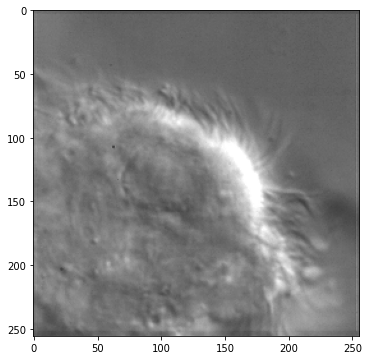

In [5]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('../data/my_dataset/img_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [6]:
import os.path as osp
import numpy as np
from PIL import Image

In [7]:
# convert dataset annotation to semantic segmentation map
data_root = '../data/my_dataset'
img_dir = 'img_dir/train'
ann_dir = 'ann_dir/train'
# define class and plaette for better visualization
classes = ('background', 'cell', 'cilia')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125]]

In [8]:
# for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
#   seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#   seg_img = Image.fromarray(seg_map).convert('P')
#   seg_img.putpalette(np.array(palette, dtype=np.uint8))
#   seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
#                                                          '.png')))

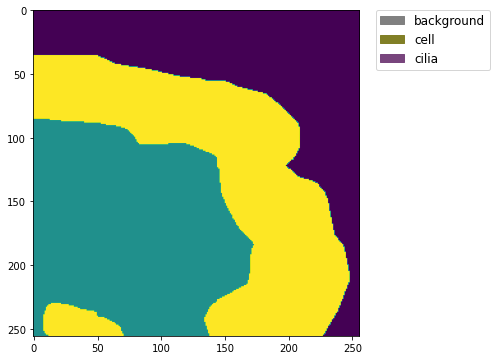

In [9]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('../data/my_dataset/ann_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [10]:
import numpy as np

In [11]:
data = np.asarray(img)
print(data.shape)

(256, 256)


In [12]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

In [13]:
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [14]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class CiliaDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [15]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [16]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'CiliaDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [17]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/esbg-lab/anaconda3/envs/GT/lib/python3.7/site-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-04-19 12:43:09,155 - mmseg - INFO - Loaded 16880 images
2021-04-19 12:43:09,605 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-04-19 12:43:11,242 - mmseg - INFO - Loaded 4220 images
2021-04-19 12:43:11,243 - mmseg - INFO - load checkpoint from checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2021-04-19 12:43:11,372 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) fr

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 52.3 task/s, elapsed: 81s, ETA:     0s

2021-04-19 12:45:34,268 - mmseg - INFO - per class results:
2021-04-19 12:45:34,269 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 87.38 | 92.93 |
| cell       | 79.15 | 92.5  |
| cilia      | 38.39 | 45.8  |
+------------+-------+-------+
2021-04-19 12:45:34,269 - mmseg - INFO - Summary:
2021-04-19 12:45:34,269 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 68.31 | 77.08 | 89.17 |
+--------+-------+-------+-------+
2021-04-19 12:45:34,276 - mmseg - INFO - Iter(val) [200]	mIoU: 0.6831, mAcc: 0.7708, aAcc: 0.8917, IoU.background: 0.8738, IoU.cell: 0.7915, IoU.cilia: 0.3839, Acc.background: 0.9293, Acc.cell: 0.9250, Acc.cilia: 0.4580


In [19]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [ ]:
from PIL import Image
im = Image.fromarray(A)
im.save("your_file.jpeg")

In [28]:
import os
rootdir = './data/my_dataset/img_dir/test/'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        print(subdir)
#         print(str(subdir).split("/")[-1])
        print(file)
#         new_name = str(subdir).split("/")[-1] +"_"+ file
#         shutil.copy(os.path.join(subdir, file), "./data/my_dataset/img_dir/test/"+new_name)

/home/esbg-lab/Desktop/P3/mmsegmentation/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

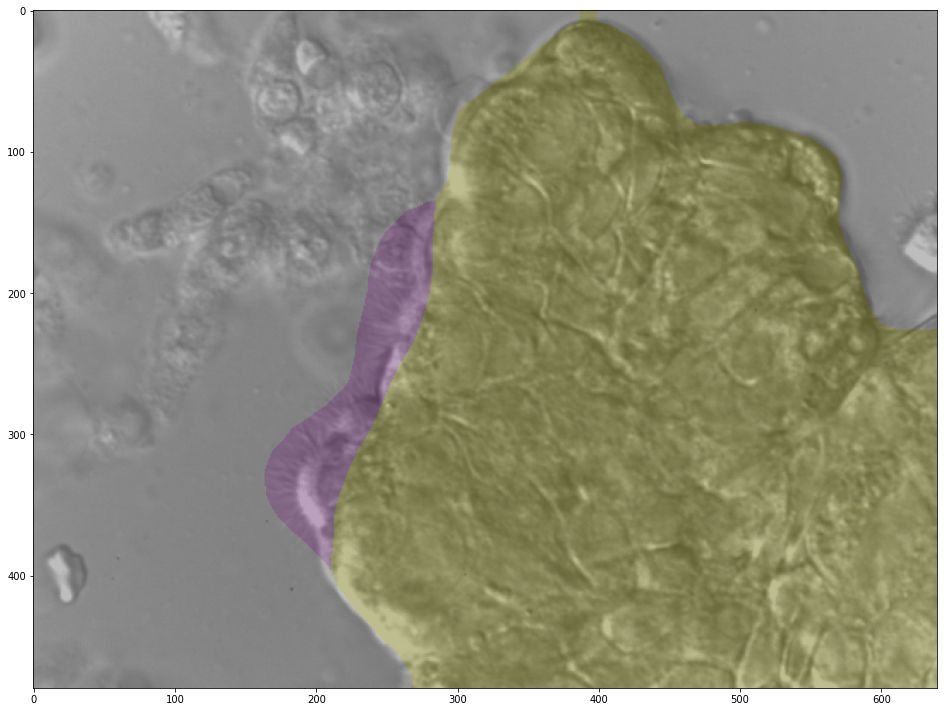

In [20]:
img = mmcv.imread('../data/my_dataset/img_dir/test/0bd52e3901cbbf4e57bd8bde4e0f7d5ba7bfc2b3b1dc4ce0dbf437d2ad374c5a_frame0000.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

In [25]:
img.shape

(480, 640, 3)

In [24]:
result[0].shape

(480, 640)